# MobileNet V2 关键创新点与缺点总结

[MobileNet V2](https://arxiv.org/abs/1801.04381 ) 是 Google 提出的一种轻量级卷积神经网络架构，专为移动端和嵌入式设备设计。相比第一代 MobileNet，它在保持高效计算的同时显著提升了模型的准确性。

---

## 关键创新点

### 1. **Inverted Residuals（倒残差结构）**

- 使用“扩展-压缩”策略：
  - 首先通过 `1x1` 卷积升维（扩展通道数）
  - 然后使用 `3x3` 深度可分离卷积提取特征
  - 最后通过 `1x1` 卷积降维（压缩通道数）
- 该结构为两头小中间大,与传统残差模块中“压缩-扩展”的两头大中间小不同，因此称为“倒置”残差。
- 这种设计可以在低维空间中保留更多信息，同时保持轻量化。

### 2. **Linear Bottleneck（线性瓶颈层）**

- 在最后的降维层中使用 **线性激活函数** 而不是 ReLU6。
- 避免了非线性激活对特征表达能力的破坏，尤其在低维空间中尤为重要。

这种设计基于如下观测: 低维流形通过线性变换升维之后在用ReLU这种非线性变换相较于降维损失更少的信息,这就是为何采用两头大中间小的结构,在使用ReLU6非线性激活函数时升维,且在降维时不采用ReLU6函数.

  ![alt text](resources/mobilenetv2_manifold.png "Title")

  ![alt text](resources/mobilenetv2_inverted_residual_block.png "Title")


In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

Use device:  cuda


In [2]:
from hdd.dataset.imagenette_in_memory import ImagenetteInMemory
from hdd.data_util.transforms import RandomResize
from torch.utils.data import DataLoader

TRAIN_MEAN = [0.4625, 0.4580, 0.4295]
TRAIN_STD = [0.2452, 0.2390, 0.2469]
train_dataset_transforms = transforms.Compose(
    [
        RandomResize([256, 296, 384]),  # 随机在三个size中选择一个进行resize
        transforms.RandomRotation(10),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
val_dataset_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
train_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="train",
    size="full",
    download=True,
    transform=train_dataset_transforms,
)
val_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="val",
    size="full",
    download=True,
    transform=val_dataset_transforms,
)


def build_dataloader(batch_size, train_dataset, val_dataset):
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
    )
    return train_dataloader, val_dataloader

In [3]:
from hdd.models.cnn.mobilenet_v2 import MobileNetV2
from hdd.train.classification_utils import (
    naive_train_classification_model,
    eval_image_classifier,
)
from hdd.models.nn_utils import count_trainable_parameter


def train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier,
    lr=1e-3,
    weight_decay=1e-5,
    max_epochs=100,
) -> tuple[MobileNetV2, dict[str, list[float]]]:
    net = MobileNetV2(num_classes=10, width_multiplier=width_multiplier).to(DEVICE)
    print(f"#Parameter: {count_trainable_parameter(net)}")
    criteria = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, max_epochs, eta_min=lr / 100
    )
    training_stats = naive_train_classification_model(
        net,
        criteria,
        max_epochs,
        train_dataloader,
        val_dataloader,
        DEVICE,
        optimizer,
        scheduler,
        verbose=True,
    )
    return net, training_stats


train_dataloader, val_dataloader = build_dataloader(64, train_dataset, val_dataset)

net, width_multiplier_1 = train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier=1,
    lr=0.001,
    weight_decay=0,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 2254858
Epoch: 1/100 Train Loss: 1.9526 Accuracy: 0.3451 Time: 9.18680  | Val Loss: 2.5894 Accuracy: 0.3320
Epoch: 2/100 Train Loss: 1.6845 Accuracy: 0.4882 Time: 8.83724  | Val Loss: 1.6842 Accuracy: 0.4963
Epoch: 3/100 Train Loss: 1.5540 Accuracy: 0.5535 Time: 11.17765  | Val Loss: 1.5913 Accuracy: 0.5743
Epoch: 4/100 Train Loss: 1.4629 Accuracy: 0.5971 Time: 13.43177  | Val Loss: 1.3255 Accuracy: 0.6583
Epoch: 5/100 Train Loss: 1.3920 Accuracy: 0.6247 Time: 14.36127  | Val Loss: 1.6434 Accuracy: 0.5567
Epoch: 6/100 Train Loss: 1.3219 Accuracy: 0.6598 Time: 13.48745  | Val Loss: 1.2349 Accuracy: 0.7108
Epoch: 7/100 Train Loss: 1.2794 Accuracy: 0.6782 Time: 13.25659  | Val Loss: 1.1590 Accuracy: 0.7299
Epoch: 8/100 Train Loss: 1.2308 Accuracy: 0.7025 Time: 13.23072  | Val Loss: 1.1284 Accuracy: 0.7483
Epoch: 9/100 Train Loss: 1.1914 Accuracy: 0.7169 Time: 14.62846  | Val Loss: 1.2165 Accuracy: 0.7279
Epoch: 10/100 Train Loss: 1.1652 Accuracy: 0.7275 Time: 14.21428  | Val L

In [4]:
net, width_multiplier_75 = train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier=0.75,
    lr=0.001,
    weight_decay=0,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 1292578
Epoch: 1/100 Train Loss: 1.9849 Accuracy: 0.3295 Time: 10.69298  | Val Loss: 1.8432 Accuracy: 0.4260
Epoch: 2/100 Train Loss: 1.7107 Accuracy: 0.4740 Time: 10.53086  | Val Loss: 2.1749 Accuracy: 0.3906
Epoch: 3/100 Train Loss: 1.5737 Accuracy: 0.5389 Time: 10.49241  | Val Loss: 1.5296 Accuracy: 0.5656
Epoch: 4/100 Train Loss: 1.4806 Accuracy: 0.5840 Time: 10.49923  | Val Loss: 1.3858 Accuracy: 0.6346
Epoch: 5/100 Train Loss: 1.4083 Accuracy: 0.6166 Time: 11.41891  | Val Loss: 1.2976 Accuracy: 0.6680
Epoch: 6/100 Train Loss: 1.3293 Accuracy: 0.6529 Time: 11.16928  | Val Loss: 1.3777 Accuracy: 0.6502
Epoch: 7/100 Train Loss: 1.3018 Accuracy: 0.6666 Time: 10.58485  | Val Loss: 1.2529 Accuracy: 0.6922
Epoch: 8/100 Train Loss: 1.2623 Accuracy: 0.6866 Time: 10.39270  | Val Loss: 1.1974 Accuracy: 0.7126
Epoch: 9/100 Train Loss: 1.2245 Accuracy: 0.6963 Time: 11.31945  | Val Loss: 1.1712 Accuracy: 0.7396
Epoch: 10/100 Train Loss: 1.1817 Accuracy: 0.7247 Time: 11.08638  | Val

In [5]:
net, width_multiplier_50 = train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier=0.5,
    lr=0.001,
    weight_decay=0,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 596010
Epoch: 1/100 Train Loss: 2.0828 Accuracy: 0.2460 Time: 8.91988  | Val Loss: 2.0095 Accuracy: 0.3266
Epoch: 2/100 Train Loss: 1.8159 Accuracy: 0.4098 Time: 8.75082  | Val Loss: 1.7573 Accuracy: 0.4428
Epoch: 3/100 Train Loss: 1.6885 Accuracy: 0.4766 Time: 8.54792  | Val Loss: 1.6885 Accuracy: 0.4741
Epoch: 4/100 Train Loss: 1.5973 Accuracy: 0.5267 Time: 8.80671  | Val Loss: 1.5289 Accuracy: 0.5643
Epoch: 5/100 Train Loss: 1.5256 Accuracy: 0.5613 Time: 8.86751  | Val Loss: 1.4175 Accuracy: 0.6092
Epoch: 6/100 Train Loss: 1.4443 Accuracy: 0.5972 Time: 8.77320  | Val Loss: 1.4652 Accuracy: 0.5952
Epoch: 7/100 Train Loss: 1.4129 Accuracy: 0.6117 Time: 8.81523  | Val Loss: 1.3391 Accuracy: 0.6540
Epoch: 8/100 Train Loss: 1.3785 Accuracy: 0.6288 Time: 9.31864  | Val Loss: 1.2794 Accuracy: 0.6795
Epoch: 9/100 Train Loss: 1.3291 Accuracy: 0.6572 Time: 8.92377  | Val Loss: 1.2585 Accuracy: 0.6884
Epoch: 10/100 Train Loss: 1.2984 Accuracy: 0.6622 Time: 8.51917  | Val Loss: 1.27

In [6]:
net, width_multiplier_25 = train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier=0.25,
    lr=0.001,
    weight_decay=0,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 165154
Epoch: 1/100 Train Loss: 2.1152 Accuracy: 0.2355 Time: 8.11122  | Val Loss: 2.0036 Accuracy: 0.2874
Epoch: 2/100 Train Loss: 1.9361 Accuracy: 0.3454 Time: 8.24223  | Val Loss: 1.8441 Accuracy: 0.4056
Epoch: 3/100 Train Loss: 1.7856 Accuracy: 0.4338 Time: 7.60871  | Val Loss: 1.7473 Accuracy: 0.4550
Epoch: 4/100 Train Loss: 1.6572 Accuracy: 0.5032 Time: 6.90610  | Val Loss: 1.5035 Accuracy: 0.5743
Epoch: 5/100 Train Loss: 1.5864 Accuracy: 0.5306 Time: 6.37236  | Val Loss: 1.4433 Accuracy: 0.6071
Epoch: 6/100 Train Loss: 1.5382 Accuracy: 0.5512 Time: 6.25545  | Val Loss: 1.4592 Accuracy: 0.5941
Epoch: 7/100 Train Loss: 1.4870 Accuracy: 0.5790 Time: 6.44015  | Val Loss: 1.4293 Accuracy: 0.6125
Epoch: 8/100 Train Loss: 1.4343 Accuracy: 0.5961 Time: 5.34771  | Val Loss: 1.4163 Accuracy: 0.6237
Epoch: 9/100 Train Loss: 1.4109 Accuracy: 0.6162 Time: 5.20524  | Val Loss: 1.3402 Accuracy: 0.6599
Epoch: 10/100 Train Loss: 1.3858 Accuracy: 0.6271 Time: 5.11364  | Val Loss: 1.30

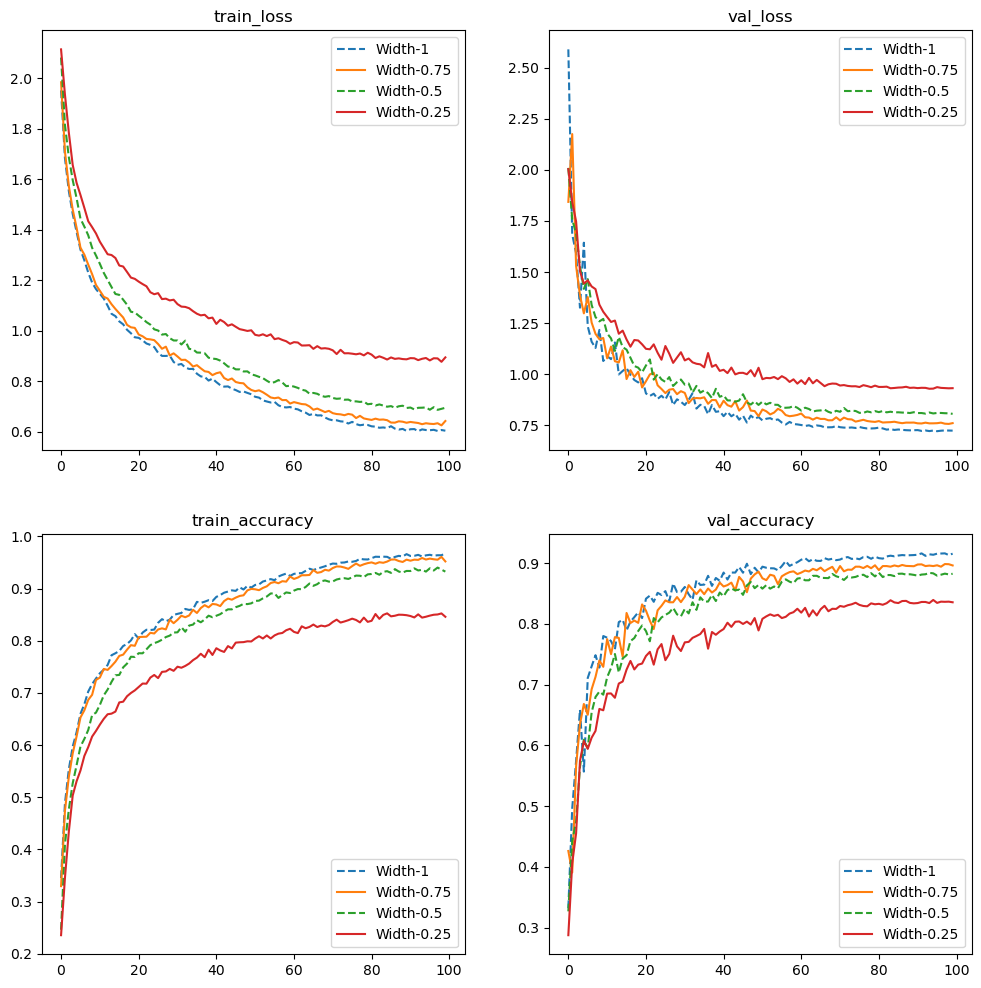

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = width_multiplier_1.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(width_multiplier_1[field], label="Width-1", linestyle="--")
    plt.plot(width_multiplier_75[field], label="Width-0.75")
    plt.plot(width_multiplier_50[field], label="Width-0.5", linestyle="--")
    plt.plot(width_multiplier_25[field], label="Width-0.25", linestyle="-")
    plt.legend()
    plt.title(field)